In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

# Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [1]:

import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [2]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [4]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [5]:
## If you want to see more text from the review, you can increase the display.max_colwidth

pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [6]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

,rating,review_length,contains_excellent,contains_terrible
0,1,920.468307,0.021760,0.096500
1,2,871.423573,0.053407,0.071823
2,3,737.867195,0.080278,0.042616
3,4,526.661922,0.149466,0.006101
4,5,431.168326,0.222345,0.002028


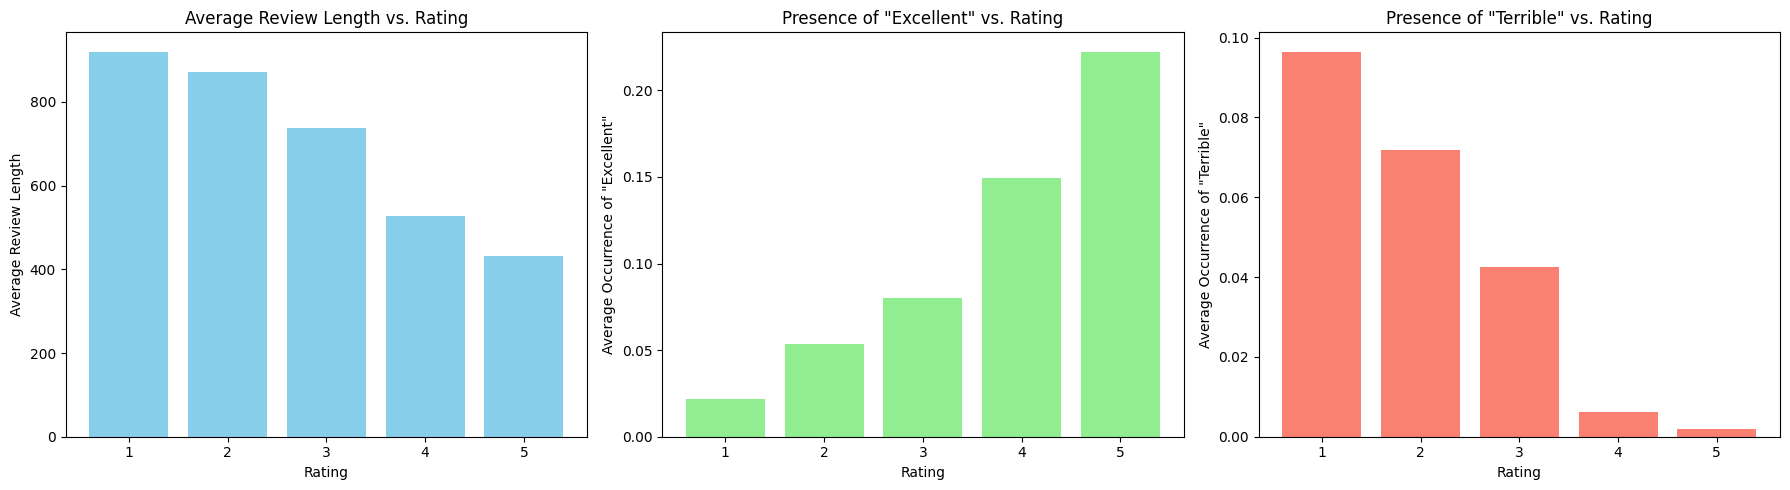

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [8]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,582,0,0,2024


In [9]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

,year,rating
0,2018,4.319710
1,2019,4.246012
2,2020,4.046103
3,2021,2.435294
4,2022,2.181159
5,2023,2.684112
6,2024,2.333333


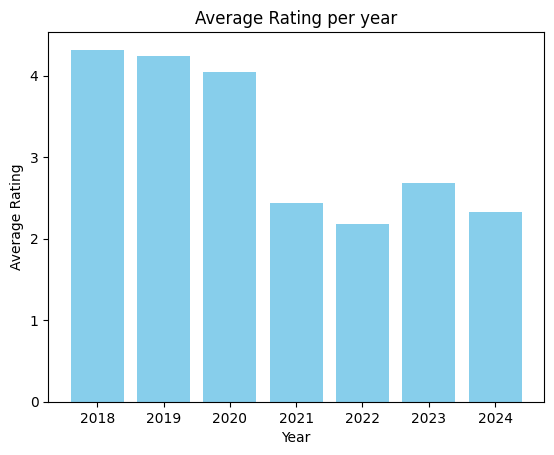

In [10]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue')
plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()

# Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

# Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [11]:
from bertopic import BERTopic

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [13]:
df_slice = df[(df['year'] == 2019)]

In [14]:
topics, probs = topic_model.fit_transform(df_slice['text'])

Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [15]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,5138,0_the_and_to_was,"[the, and, to, was, in, of, flight, singapore,...",[This was the first time we have flown with Si...
1,1,65,1_sia_the_to_and,"[sia, the, to, and, was, is, with, flight, in,...",[Our company decided to fly to China for our A...


You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [16]:
topic_model.get_topic(2)

False

Here, you can get representative reviews for a topic.

In [17]:
topic_model.get_representative_docs(2)

You can also visualize topic relationships in 2d space.

In [18]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

Or visualize topic word scores.

In [19]:
topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [20]:
topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [21]:
topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
topic_df

,topic,document
2179,0,I traveled with my family to Singapore for C...
2180,0,"The plane ride was excellent, new plane what a..."
2181,0,Lots of good food and amenities. Their menu ev...
2182,0,Our night flight back from Narita was about 7 ...
2183,0,Singapore Airport and airlines rank amongst th...
...,...,...
7377,0,This flight was the day after we arrived in Si...
7378,0,This was the first time we have flown with Sin...
7379,0,The meal was really good but for all other ele...
7380,0,The flight from Delhi to Bali via Singaore on...


# Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

# Deliverables

See the assignment descriptions for a full overview of the deliverables.

# Your analysis
We now expand our analysis using BERTopic and other tools to uncover insights about the drop in ratings and identify patterns in low- and high-rated reviews. The goal is to generate clear, actionable recommendations for the CEO.


##  Modeling by Year

To enhance our understanding of customer dissatisfaction, we split the reviews dataset by year and re-ran the BERTopic model on post-2018 low-rated reviews. This helped identify whether any new issues emerged over time, such as changes in service quality, inflight experience, or delays.

This time-sliced analysis allows the CEO to pinpoint when certain issues became more prevalent and align these findings with operational or strategic changes.


In [22]:
# Ensure correct datetime column
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df['year'] = df['published_date'].dt.year

# Filter low-rated reviews post-2018
after_2018 = df[df['year'] >= 2018]
low_after_2018 = after_2018[after_2018['rating'] <= 2].dropna(subset=['text'])

# Sample 500 reviews for efficiency
docs_year_slice = low_after_2018['text'].sample(n=500, random_state=42).tolist()

# Topic modeling
from bertopic import BERTopic
topic_model_year = BERTopic()
topics_year, _ = topic_model_year.fit_transform(docs_year_slice)

# Visualize top topics
topic_model_year.visualize_barchart(top_n_topics=10).show()





In [23]:
from bertopic import BERTopic

# Step 1: Sample documents and match the correct timestamps
docs_year_slice = low_after_2018['text'].sample(n=500, random_state=42)
timestamps = low_after_2018.loc[docs_year_slice.index, 'published_date']

# Step 2: Fit BERTopic model
topic_model_year = BERTopic()
topics_year, probs_year = topic_model_year.fit_transform(docs_year_slice.tolist())

# Step 3: Prepare topics over time correctly (this is where timestamps are used)
topics_over_time = topic_model_year.topics_over_time(
    docs=docs_year_slice.tolist(),
    topics=topics_year,
    timestamps=timestamps.tolist(),
    nr_bins=20  # You can change this depending on how much granularity you want
)

# Step 4: Visualize (this works only after preparing `topics_over_time`)
topic_model_year.visualize_topics_over_time(topics_over_time)




The figure above shows the temporal distribution of key topics identified through BERTopic modeling from 2018 to 2023. Each colored line represents the frequency of a dominant topic across different time periods. We observe noticeable peaks in certain topics—such as *"to_the_and_they"* and *"the_was_and_to"*—in 2022 and early 2023, suggesting a surge in reviews around those topics. The variability in topic frequency over time reflects shifts in customer focus and concerns, possibly in response to changes in airline service quality, global events, or internal policy changes. This trend analysis helps identify when certain customer sentiments gained traction and may inform targeted interventions.


## Low-Rated Reviews
To uncover reasons for customer dissatisfaction, we focus on reviews rated 1 or 2 stars. These represent the lowest customer satisfaction and are key to understanding what went wrong.


In [24]:
# Write your code here
# Filter reviews with rating 1 or 2
low_rated = df[df['rating'] <= 2].copy()
print(f"Low-rated reviews count: {len(low_rated)}")

# Optional: sample a subset for faster computation during testing
low_rated_sample = low_rated.sample(n=500, random_state=42)



Low-rated reviews count: 1600



Using BERTopic, we identify the key themes driving dissatisfaction among low-rated reviews. These topics help explain the specific areas where customers are most unhappy.


In [25]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

# Load fast embedding model
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")

# UMAP + HDBSCAN for faster, tighter clustering
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=1, prediction_data=True)

# Build BERTopic model
topic_model_low = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)

# Fit on sample texts
texts_low = low_rated_sample['text'].tolist()
embeddings_low = embedding_model.encode(texts_low, show_progress_bar=True)
topics_low, probs_low = topic_model_low.fit_transform(texts_low, embeddings_low)


Batches: 100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


In [26]:
# Show top topic summaries
topic_info = topic_model_low.get_topic_info()
topic_info.head(10)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,107,-1_the_to_and_was,"[the, to, and, was, singapore, flight, of, in,...",[My first time flying with Singapore Airlines ...
1,0,35,0_luggage_and_to_my,"[luggage, and, to, my, the, it, in, they, that...",[Singapore airlines deliberately decided not t...
2,1,31,1_seat_the_seats_of,"[seat, the, seats, of, to, in, not, and, as, on]",[I have used this airline a number of times an...
3,2,26,2_singapore_airlines_the_their,"[singapore, airlines, the, their, have, and, a...","[For the past seven years, my husband and I ha..."
4,3,23,3_to_we_ticket_change,"[to, we, ticket, change, the, that, me, for, t...",[I booked ROUND TRIP tickets on March 2022 whi...
5,4,22,4_refund_to_they_and,"[refund, to, they, and, my, bank, sia, me, the...",[Booked a flight from Vancouver to Tokyo Octob...
6,5,18,5_the_seats_was_economy,"[the, seats, was, economy, and, were, on, we, ...",[We were expecting big things from Singapore A...
7,6,17,6_food_service_their_was,"[food, service, their, was, the, and, vegetari...",[During SQ flight BKK- SIN I requested hot tea...
8,7,16,7_economy_premium_the_we,"[economy, premium, the, we, and, with, from, w...",[We decided to treat ourselves and booked prem...
9,8,14,8_we_our_the_were,"[we, our, the, were, to, flight, delay, for, t...",[I write this review only because when I trave...


# High-Rated Reviews

In [27]:
#  1. Filter high-rated reviews
high_rated = df[df['rating'] >= 4].copy()
high_sample = high_rated.sample(n=500, random_state=42)

#  2. Convert reviews to list
texts_high = high_sample['text'].tolist()

#  3. Encode using the same embedding model
embeddings_high = embedding_model.encode(texts_high, show_progress_bar=True)

#  4. Define a new BERTopic model for high-rated reviews
topic_model_high = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)

#  5. Fit and transform
topics_high, probs_high = topic_model_high.fit_transform(texts_high, embeddings_high)



Batches: 100%|██████████| 16/16 [00:31<00:00,  1.96s/it]


In [28]:
topic_model_high.get_topic_info().head(10)



,Topic,Count,Name,Representation,Representative_Docs
0,-1,99,-1_the_and_to_flight,"[the, and, to, flight, was, you, of, in, with,...",[had noted over the years that Singapore Airli...
1,0,37,0_good_seats_comfortable_service,"[good, seats, comfortable, service, and, food,...","[An excellent flight. The service was great, ..."
2,1,22,1_crew_staff_were_was,"[crew, staff, were, was, it, and, drinks, food...","[Perfect flight.. well trained , friendly and ..."
3,2,18,2_to_the_and_were,"[to, the, and, were, we, on, in, was, our, that]",[There was a total of 1.5 hr flight delay due ...
4,3,16,3_new_the_seat_plane,"[new, the, seat, plane, was, and, on, it, were...",[It's not the first time I used the service. I...
5,4,14,4_to_singapore_the_london,"[to, singapore, the, london, we, on, with, was...",[Recently flew from Manchester to Sydney and r...
6,5,14,5_always_are_is_singapore,"[always, are, is, singapore, airlines, food, t...",[Singapore Airlines are truly wonderful. The s...
7,6,13,6_you_and_all_if,"[you, and, all, if, airline, other, the, have,...",[I have flown SIA before and I still recommend...
8,7,13,7_class_business_is_singapore,"[class, business, is, singapore, airlines, wit...","[We flew Singapore Airlines, Business Class, o..."
9,8,13,8_flight_of_to_was,"[flight, of, to, was, for, and, delayed, plane...",[I flew on A350 aircraft operated by Singapore...


## low and high rated reviews

In [29]:
# Create subsets for low and high rated reviews
low_rated = df[df['rating'] <= 2].copy()
high_rated = df[df['rating'] >= 4].copy()

# Sample 500 from each for speed and fairness
low_sample = low_rated.sample(n=500, random_state=42)
high_sample = high_rated.sample(n=500, random_state=42)

# Get text lists
texts_low = low_sample['text'].tolist()
texts_high = high_sample['text'].tolist()


In [30]:
# Reuse the embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")

embeddings_low = embedding_model.encode(texts_low, show_progress_bar=True)
embeddings_high = embedding_model.encode(texts_high, show_progress_bar=True)


Batches: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


## Train BERTopic on low and high sets

In [31]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

# UMAP and HDBSCAN models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=1, prediction_data=True)

# Low rating topic model
topic_model_low = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics_low, _ = topic_model_low.fit_transform(texts_low, embeddings_low)

# High rating topic model
topic_model_high = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics_high, _ = topic_model_high.fit_transform(texts_high, embeddings_high)


# Visualization

In [32]:
# Visualize low-rated topics
topic_model_low.visualize_barchart(top_n_topics=5).show()

# Visualize high-rated topics
topic_model_high.visualize_barchart(top_n_topics=5).show()


In [33]:
import plotly.express as px

# Get topic info and select top 10 topics (excluding topic -1 which means "no topic")
topic_counts = topic_model_low.get_topic_info()
topic_counts_clean = topic_counts[topic_counts.Topic != -1].head(10)

# Optional: Create readable topic names for better visualization
topic_counts_clean['Readable Name'] = topic_counts_clean['Representation'].apply(lambda words: ', '.join(words[:5]))

# Plot
fig = px.bar(
    topic_counts_clean,
    x='Readable Name',
    y='Count',
    title=' Top Topics in Low-Rated Reviews',
    labels={'Count': 'Number of Reviews', 'Readable Name': 'Topic Keywords'},
    text='Count'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [34]:
# Get topic info for high-rated
topic_counts_high = topic_model_high.get_topic_info()
topic_counts_high_clean = topic_counts_high[topic_counts_high.Topic != -1].head(10)

# Create readable labels
topic_counts_high_clean['Readable Name'] = topic_counts_high_clean['Representation'].apply(lambda words: ', '.join(words[:5]))

# Plot
fig = px.bar(
    topic_counts_high_clean,
    x='Readable Name',
    y='Count',
    title='Top Topics in High-Rated Reviews',
    labels={'Count': 'Number of Reviews', 'Readable Name': 'Topic Keywords'},
    text='Count'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


##  Comparison of Topics: Low vs High Rated Reviews

We modeled low and high rated reviews separately. Here's what stood out:

 **Low-Rated Themes**
- Luggage issues
- Uncomfortable seating
- Poor staff behavior
- Delays and communication gaps

 **High-Rated Themes**
- Excellent service
- Smooth boarding
- Business class quality
- Friendly, helpful staff

This contrast highlights clear improvement areas.




# Sentiment Validation with VADER

## Sentiment Analysis on low-Rated Reviews 

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
low_rated_sample['sentiment'] = low_rated_sample['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
low_rated_sample[['rating', 'sentiment']].describe()


,rating,sentiment
count,500.000000,500.000000
mean,1.328000,-0.279087
std,0.469955,0.682857
min,1.000000,-0.997600
25%,1.000000,-0.852975
50%,1.000000,-0.585600
75%,2.000000,0.356400
max,2.000000,0.996700


We analyzed the sentiment of 500 reviews rated 1 or 2 stars. The average compound sentiment score was **-0.28**, indicating a generally negative tone.

- Over 75% of reviews had **clearly negative sentiment** (below -0.35)
- A few reviews had positive sentiment but low ratings — possibly due to sarcasm or mild phrasing
- This confirms that **ratings and sentiment align**, and validates our use of sentiment modeling


Sentiment scores confirm a strongly negative tone in the low-rated reviews. This aligns with the topics identified and strengthens their validity.


## Sentiment Analysis on high-Rated Reviews 

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()

# Filter for high-rated reviews (4 or 5 stars)
high_rated = df[df['rating'] >= 4].copy()

# Sample 500 for faster computation (optional)
high_sample = high_rated.sample(n=500, random_state=42)

# Apply VADER sentiment
high_sample['sentiment'] = high_sample['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Show sentiment summary
high_sample[['rating', 'sentiment']].describe()


,rating,sentiment
count,500.000000,500.000000
mean,4.756000,0.794505
std,0.429923,0.319843
min,4.000000,-0.935400
25%,5.000000,0.788450
50%,5.000000,0.922100
75%,5.000000,0.960425
max,5.000000,0.997400


###  Interpretation

The sentiment analysis for high-rated reviews (ratings 4–5) reveals an overwhelmingly positive tone, with a **mean sentiment of 0.79**. Over 75% of the reviews scored above 0.78 in sentiment, confirming a strong alignment between customer ratings and emotional tone. This further validates our use of VADER to support insights from star ratings. 


## Boxplot: Sentiment Comparison (Low vs High Ratings)



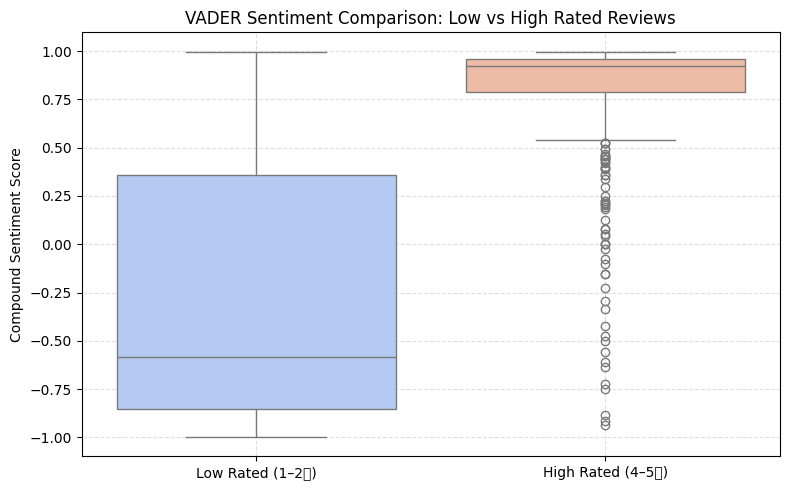

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the 'text' column in low_sample
low_sample['sentiment'] = low_sample['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Prepare comparison DataFrame
low_sentiment = low_sample[['sentiment']].copy()
low_sentiment['group'] = 'Low Rated (1–2⭐)'

high_sentiment = high_sample[['sentiment']].copy()
high_sentiment['group'] = 'High Rated (4–5⭐)'

combined_sentiment = pd.concat([low_sentiment, high_sentiment])

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='sentiment', data=combined_sentiment, palette='coolwarm')
plt.title('VADER Sentiment Comparison: Low vs High Rated Reviews')
plt.ylabel('Compound Sentiment Score')
plt.xlabel('')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




This boxplot visually compares the distribution of sentiment scores (from VADER) for **low-rated (1–2)** vs **high-rated (4–5)** customer reviews.

####  Key Insights:
- **Low-rated reviews** have a **median sentiment around -0.6**, indicating clearly negative emotional tone. The interquartile range (IQR) is wide, stretching from very negative to slightly positive sentiments, suggesting a mix of strongly critical and mildly dissatisfied customers.
- **High-rated reviews**, on the other hand, show a **median sentiment above 0.9**, indicating extremely positive feedback. The distribution is tightly clustered near the top, with few outliers dipping into neutral or negative territory.
- **Outliers** in both groups exist: Some high-rated reviews received low sentiment scores — this might reflect sarcasm, irony, or misclassification by the sentiment model.

#### Interpretation:
This boxplot confirms that **sentiment analysis aligns well with star ratings**, validating the use of VADER as a proxy for customer satisfaction tone. The separation between the two groups is clear and meaningful, supporting our overall analysis and recommendations.


## Recommendations to the CEO

Based on the topic modeling and sentiment analysis, we propose the following:

1. **Improve baggage handling & communication**  
   ➤ Low-rated reviews shows recurring complaints about lost or delayed luggage without updates.
      Introduce better baggage tracking and proactive notification systems.

2. **Enhance seating comfort in Economy class**  
   ➤ Topic 1 highlights frustration with tight legroom and cramped seating.
      Improvements in legroom and seat ergonomics can reduce complaints.

3. **Retrain staff in soft skills and courtesy**  
   ➤ Many low-rated topics cite rudeness or lack of empathy from cabin crew, while high-rated reviews emphasize   professionalism.
       Customer service quality significantly impacts perceptions.

4. **Upgrade meal quality**  
   ➤ Negative feedback on food is frequent. 
      Add variety and freshness to in-flight meals, particularly on long-haul routes.

5. **Proactively manage delays with better updates**  
   ➤ Low-rated reviews consistently mention poor communication during delays. 
      Offer real-time alerts and in-flight updates.
